# Lab 3: Using a sequence model for line text recognition


### Goal of the lab
* Use sequence modeling to be able to handle overlapping characters (input sequence no longer maps neatly onto output sequence).


### Outline
* Overview of the model, network, and loss
* Train an LSTM on EMNIST



In [1]:
!git clone https://github.com/full-stack-deep-learning/fsdl-text-recognizer-project.git


Cloning into 'fsdl-text-recognizer-project'...
remote: Enumerating objects: 2044, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 2044 (delta 13), reused 13 (delta 7), pack-reused 2005
Receiving objects: 100% (2044/2044), 6.16 MiB | 27.17 MiB/s, done.
Resolving deltas: 100% (1410/1410), done.


In [2]:
cd fsdl-text-recognizer-project/lab3/

/content/fsdl-text-recognizer-project/lab3


### W&B Configuration

In [3]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 143 kB 54.8 MB/s 
     |████████████████████████████████| 180 kB 39.5 MB/s 
     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=019d04285fab96a4b3cea8430cd61658fe477f04229a0bf03dd9eebf44a1e4d9
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=95b1b85b2f54d13b3a82c5d907c7bb646e45ad7ada1e6302a90f610e89efd0bf
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [4]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Looking at the EMNIST dataset

In [5]:
!pip install boltons

     |████████████████████████████████| 193 kB 5.1 MB/s 


In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.datasets.emnist_dataset import EmnistDataset

In [7]:
emnist_data = EmnistDataset()
print(emnist_data)

EMNIST Dataset
Num classes: 80
Mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z', 62: ' ', 63: '!', 64: '"', 65: '#', 66: '&', 67: "'", 68: '(', 69: ')', 70: '*', 71: '+', 72: ',', 73: '-', 74: '.', 75: '/', 76: ':', 77: ';', 78: '?', 79: '_'}
Input shape: [28, 28]



In [8]:
emnist_data.load_or_generate_data()
emnist_data.x_train.shape, emnist_data.y_train.shape

709MB [00:22, 32.8MB/s]                           


Computing SHA-256...
Unzipping EMNIST...
Loading training data from .mat file
Balancing classes to reduce amount of data
Saving to HDF5 in a compressed format...
Saving essential dataset parameters to text_recognizer/datasets...
Cleaning up...


((336299, 28, 28), (336299, 80))

In [9]:
emnist_data.x_test.shape, emnist_data.y_test.shape

((55789, 28, 28), (55789, 80))

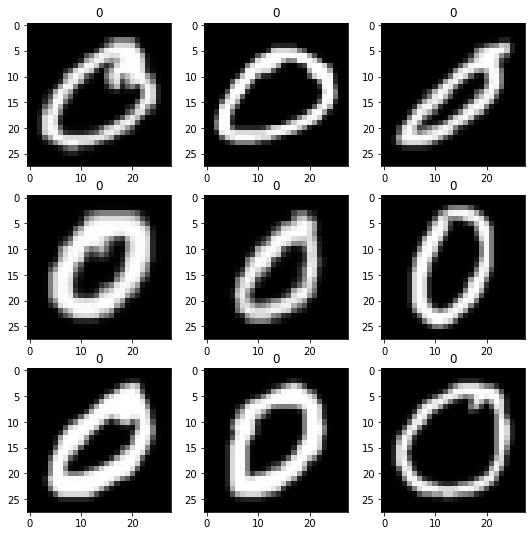

In [10]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(emnist_data.x_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(emnist_data.mapping[np.argmax(emnist_data.y_train[i])])

#### Look at the EMNIST dataset lines

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.datasets.emnist_lines_dataset import EmnistLinesDataset, construct_image_from_string, get_samples_by_char
from text_recognizer.datasets.sentence_generator import SentenceGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Synthetic dataset

In [13]:
sentence_generator = SentenceGenerator()
for _ in range(8):
    print(sentence_generator.generate(max_length=8))

in______
the_____
child___
and_____
hoped___
on______
the_____
mount___


In [14]:
dataset = EmnistLinesDataset(max_length=8, max_overlap=0)
dataset.load_or_generate_data()
print(dataset)

EmnistLinesDataset generating data...
EmnistLinesDataset generating data...
EmnistLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Max length: 8
Min overlap: 0
Max overlap: 0
Num classes: 80
Input shape: (28, 224)
Train: (10000, 28, 224) (10000, 8, 80)
Test: (1000, 28, 224) (1000, 8, 80)



In [15]:
print('Mapping:', dataset.mapping)


Mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z', 62: ' ', 63: '!', 64: '"', 65: '#', 66: '&', 67: "'", 68: '(', 69: ')', 70: '*', 71: '+', 72: ',', 73: '-', 74: '.', 75: '/', 76: ':', 77: ';', 78: '?', 79: '_'}


> Note that the last character is a padding character



In [16]:
def convert_y_label_to_string(y, dataset=dataset):
    return ''.join([dataset.mapping[i] for i in np.argmax(y, axis=-1)])

y_example = dataset.y_train[0]
print(y_example, y_example.shape)
convert_y_label_to_string(dataset.y_train[0])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1

'to______'

to______
an______
to his__
a_______
the_____
Tribal__
in______
fatal___
gone____


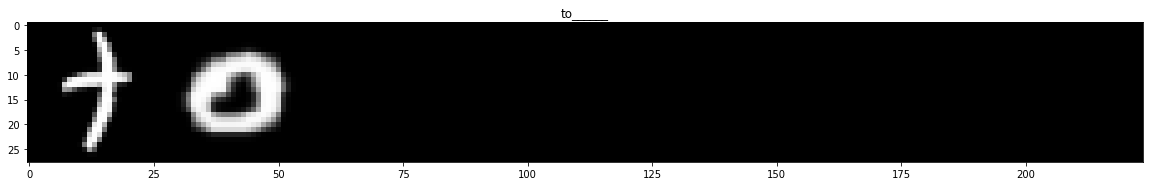

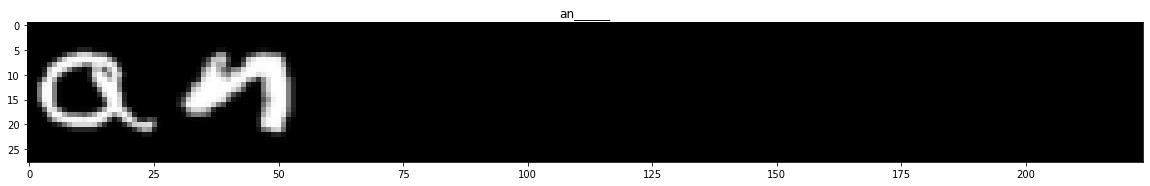

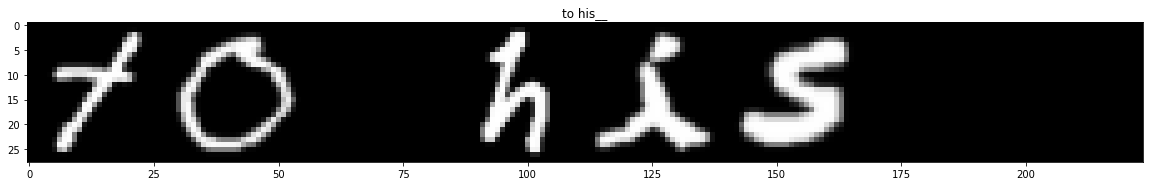

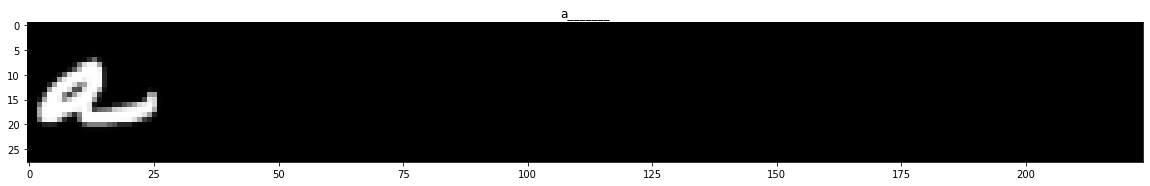

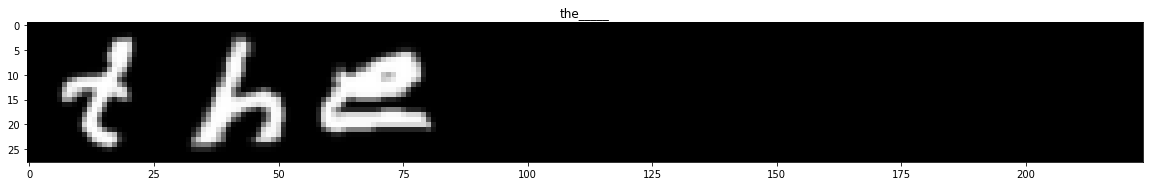

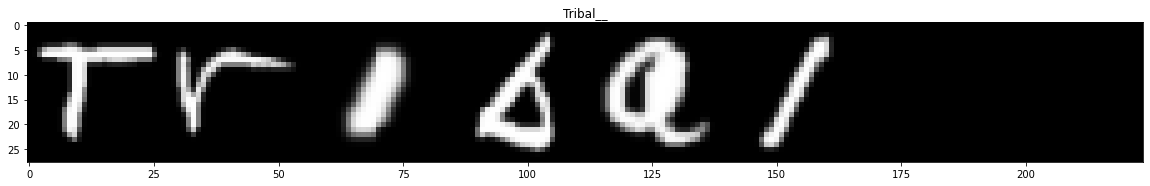

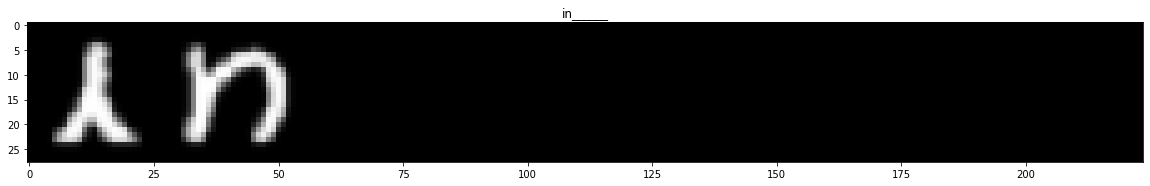

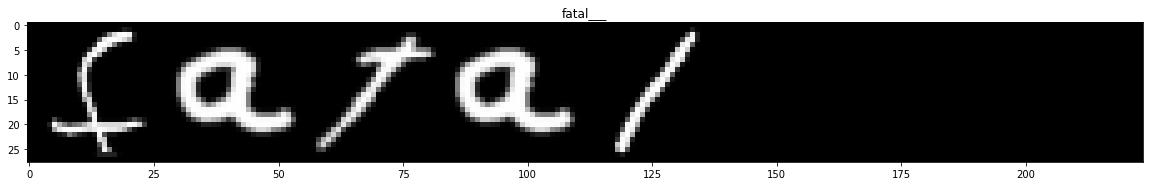

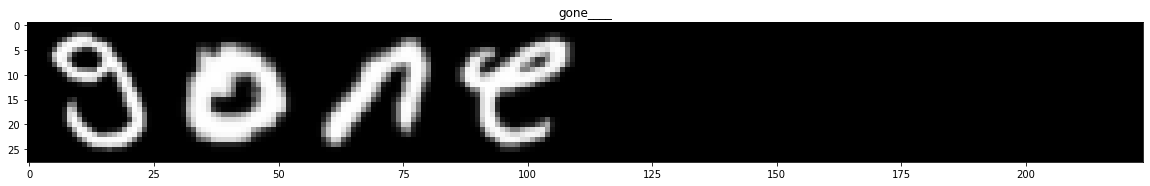

In [17]:
num_samples_to_plot = 9

for i in range(num_samples_to_plot):
    plt.figure(figsize=(20, 20))
    sentence = convert_y_label_to_string(dataset.y_train[i]) 
    print(sentence)
    plt.title(sentence)
    plt.imshow(dataset.x_train[i], cmap='gray')

### Train LSTM model with CTC loss

Let's train an LSTM model with CTC loss.



In [18]:
run training/run_experiment.py --save '{"train_args": {"epochs": 16}, "dataset": "EmnistLinesDataset", "model": "LineModelCtc", "network": "line_lstm_ctc"}'

ModuleNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

> They forgot to upload the "gpu_manager" file that why we get the following error.